In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
from lifelines import CoxPHFitter
import numpy as np
from lifelines import KaplanMeierFitter
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch

In [ ]:
df = pd.read_csv('../../data/relationships/relations_minified_versioning.csv')
## Data Preprocessing
df['is_out_of_date'] = df['is_out_of_date'].map({'t': True, 'f': False})
df['is_exposed'] = df['is_exposed'].map({'t': True, 'f': False})
df['interval_start_days'] = pd.to_numeric(df['interval_start_days'], errors='coerce')
df = df.dropna(subset=['interval_start_days'])
df['interval_end_days'] = pd.to_numeric(df['interval_end_days'], errors='coerce') ##coerce the errors to drop /N (NA) value in data
df = df.dropna(subset=['interval_end_days'])

df.dtypes

df.head

df.requirement_type.unique()

array(['pinned', 'floating - minor', 'other', 'floating - patch',
       'floating - major', 'floating - major - restrictive'], dtype=object)

In [7]:
# Sorting has effect on the model since the model expects the data for each individual together
df.sort_values(by=['dependency_id', 'interval_start_days', 'interval_end_days'], inplace=True)
print(df)
print(df.requirement_type.unique())

         dependency_id                      dependency_key  \
5253                12  CARGO|ab_glyph|ab_glyph_rasterizer   
243                 12  CARGO|ab_glyph|ab_glyph_rasterizer   
4756                12  CARGO|ab_glyph|ab_glyph_rasterizer   
3020                12  CARGO|ab_glyph|ab_glyph_rasterizer   
2137                12  CARGO|ab_glyph|ab_glyph_rasterizer   
...                ...                                 ...   
1559738        1559743         PYPI|zeroconf|async-timeout   
1559739        1559743         PYPI|zeroconf|async-timeout   
1559742        1559743         PYPI|zeroconf|async-timeout   
1559740        1559743         PYPI|zeroconf|async-timeout   
1559741        1559743         PYPI|zeroconf|async-timeout   

         interval_start_days  interval_end_days  requirement_type  \
5253                       0                6.0  floating - minor   
243                        6               13.0  floating - minor   
4756                      13               20.0 

## Visualizing the Dependency Requirement Types

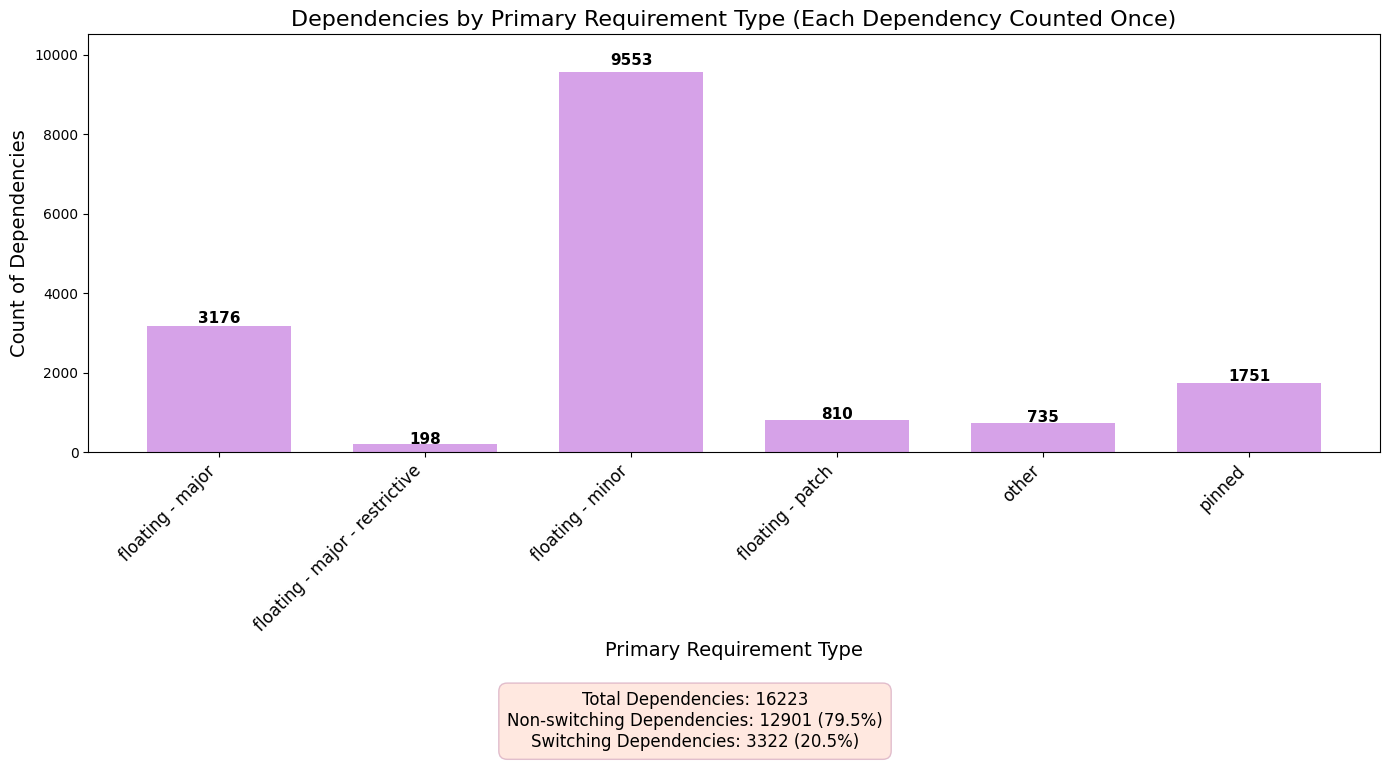

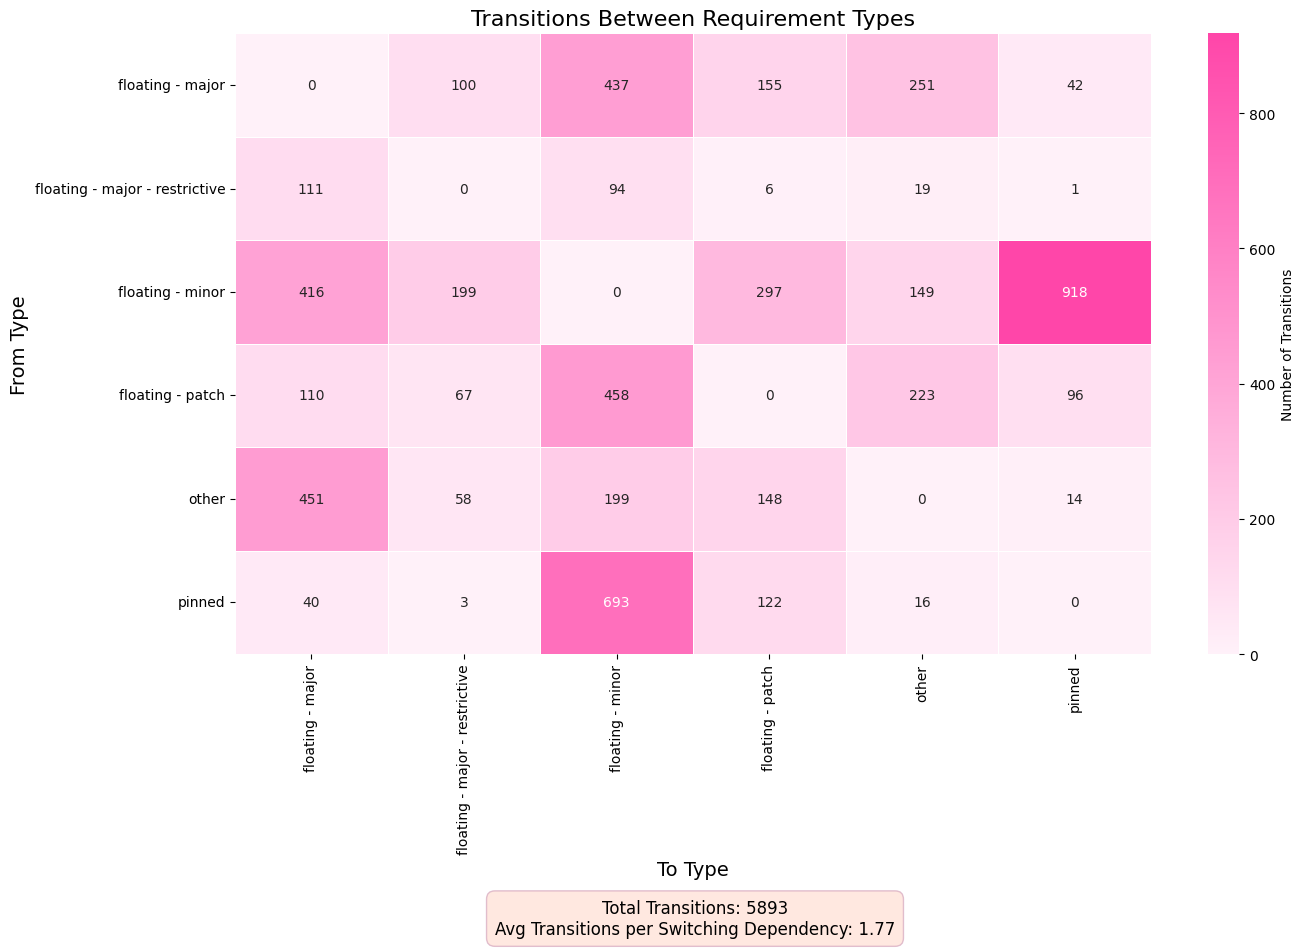

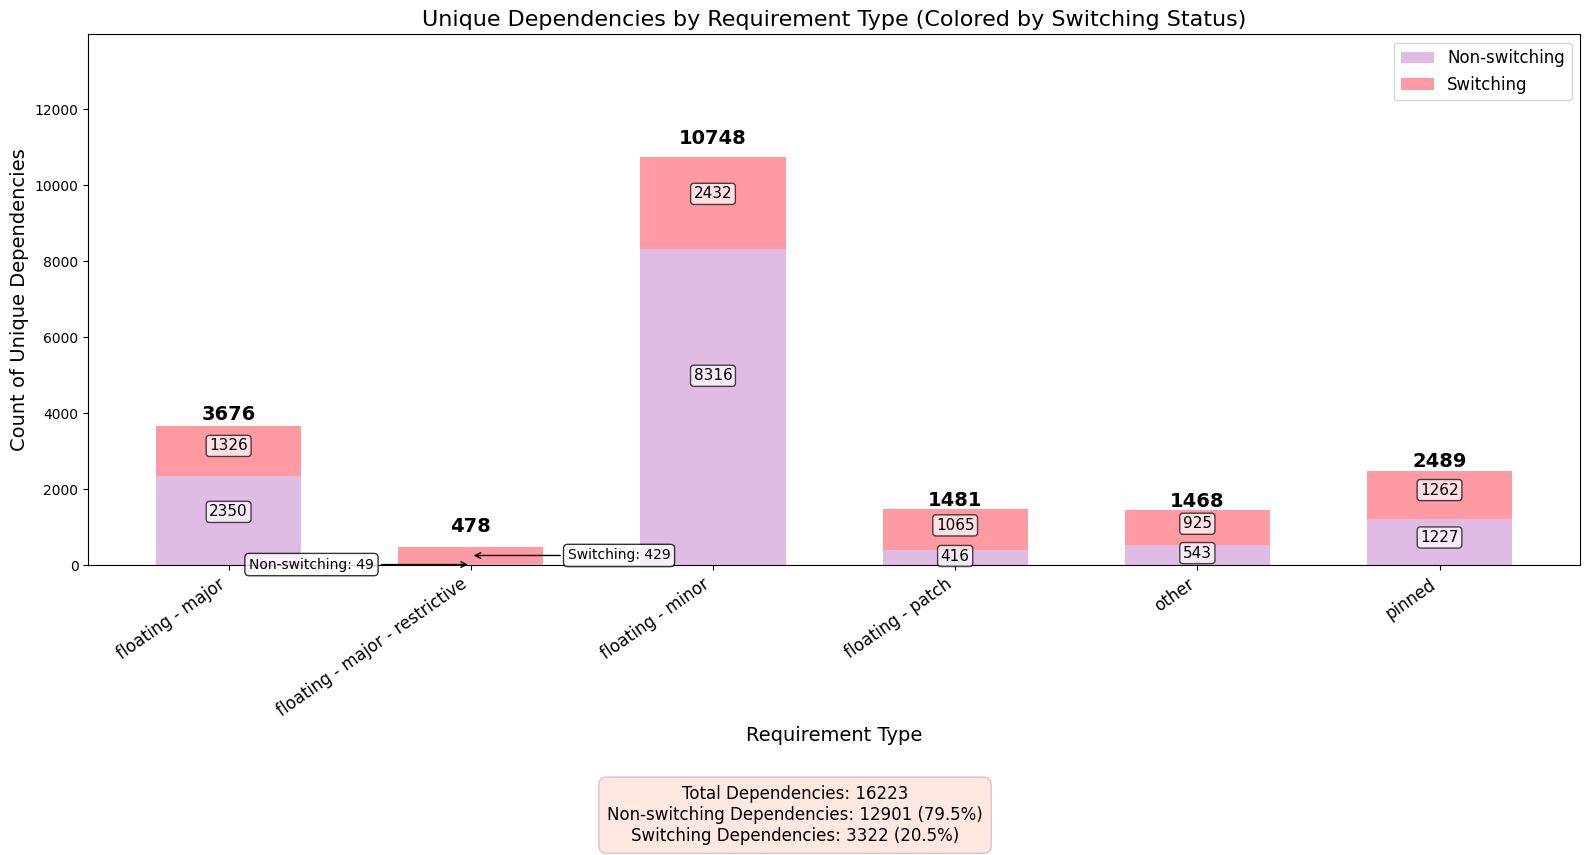

In [8]:
# Assuming df is already loaded with your data

# Part 1: Find dependencies that switch between requirement types
# Group by dependency_id and count unique requirement types
dependency_switches = df.groupby('dependency_id')['requirement_type'].nunique()
# Filter for dependencies with more than 1 requirement type
switching_deps = dependency_switches[dependency_switches > 1]
non_switching_deps = dependency_switches[dependency_switches == 1]

# Get the primary requirement type for each dependency (most common or first)
# For exclusive counts, we'll use the most frequent requirement type for each dependency
req_type_by_dep = df.groupby(['dependency_id', 'requirement_type']).size().reset_index(name='count')
primary_req_type = req_type_by_dep.sort_values(['dependency_id', 'count'], ascending=[True, False]) \
                                 .drop_duplicates('dependency_id')

# Count dependencies by their primary requirement type
exclusive_counts = primary_req_type.groupby('requirement_type').size()

# Create a DataFrame to track switching patterns
switching_patterns = pd.DataFrame(columns=['dependency_id', 'from_type', 'to_type', 'count'])

# For each switching dependency, find the transition patterns
rows = []
for dep_id in switching_deps.index:
    dep_data = df[df['dependency_id'] == dep_id]
    # Get the sequence of requirement types for this dependency
    req_sequence = dep_data['requirement_type'].tolist()
    
    # Track transitions between consecutive requirement types
    for i in range(len(req_sequence) - 1):
        from_type = req_sequence[i]
        to_type = req_sequence[i + 1]
        if from_type != to_type:  # Only count actual transitions
            rows.append({
                'dependency_id': dep_id,
                'from_type': from_type,
                'to_type': to_type,
                'count': 1
            })

if rows:
    switching_patterns = pd.DataFrame(rows)
    # Aggregate counts for same type transitions
    switching_patterns = switching_patterns.groupby(['from_type', 'to_type']).sum().reset_index()

# PLOT 1: Exclusive counts (each dependency counted only once)
plt.figure(figsize=(14, 8))

# Create a pretty pink color palette
exclusive_color = '#D6A2E8'  # Light purple

bars = plt.bar(exclusive_counts.index, exclusive_counts.values, color=exclusive_color, width=0.7)

plt.title('Dependencies by Primary Requirement Type (Each Dependency Counted Once)', fontsize=16)
plt.xlabel('Primary Requirement Type', fontsize=14)
plt.ylabel('Count of Dependencies', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.ylim(0, max(exclusive_counts.values) * 1.1)  # Add more space at the top

# Add the count values on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + (height * 0.02) + 5,
            f'{int(height)}', ha='center', fontsize=11, fontweight='bold')

# Add information about switching dependencies
plt.figtext(0.5, 0.01, 
            f'Total Dependencies: {len(dependency_switches)}\n'
            f'Non-switching Dependencies: {len(non_switching_deps)} ({len(non_switching_deps)/len(dependency_switches)*100:.1f}%)\n'
            f'Switching Dependencies: {len(switching_deps)} ({len(switching_deps)/len(dependency_switches)*100:.1f}%)', 
            ha='center', fontsize=12, bbox=dict(facecolor='#FFDFD3', alpha=0.7, boxstyle='round,pad=0.5', edgecolor='#D5A6BD'))

plt.tight_layout(rect=[0, 0.1, 1, 0.95])
plt.show()

# PLOT 2: Transitions between requirement types with colored segments
if rows:
    # Create a pivot table for the heatmap
    pivot_data = switching_patterns.pivot_table(
        index='from_type', 
        columns='to_type', 
        values='count', 
        fill_value=0
    )
    
    plt.figure(figsize=(14, 10))
    
    # Custom pink colormap
    colors = ["#FFF1F9", "#FFDBEF", "#FFC6E5", "#FFB0DB", "#FF9AD1", "#FF85C7", "#FF70BD", "#FF5BB3", "#FF46A9"]
    cmap = LinearSegmentedColormap.from_list("pretty_pinks", colors)
    
    # Plot the heatmap with improved annotations
    ax = sns.heatmap(pivot_data, annot=True, cmap=cmap, fmt='g', linewidths=0.5,
                cbar_kws={'label': 'Number of Transitions'})
    
    # Improve the appearance
    plt.title('Transitions Between Requirement Types', fontsize=16)
    plt.xlabel('To Type', fontsize=14)
    plt.ylabel('From Type', fontsize=14)
    
    # Add legend for switching dependencies with prettier box
    total_transitions = switching_patterns['count'].sum()
    plt.figtext(0.5, 0.01, 
                f'Total Transitions: {total_transitions}\n'
                f'Avg Transitions per Switching Dependency: {total_transitions/len(switching_deps):.2f}', 
                ha='center', fontsize=12, bbox=dict(facecolor='#FFDFD3', alpha=0.7, boxstyle='round,pad=0.5', edgecolor='#D5A6BD'))
    
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()

# PLOT 3: Requirement type distribution colored by switching vs non-switching
# Get counts by requirement type for switching and non-switching dependencies
switching_ids = switching_deps.index.tolist()

# Create a new dataframe with dependency_id and switching status
dep_status = pd.DataFrame({
    'dependency_id': dependency_switches.index,
    'is_switching': [dep_id in switching_ids for dep_id in dependency_switches.index]
})

# Merge with the original data
df_with_status = pd.merge(df, dep_status, on='dependency_id')

# Now count unique dependencies by requirement type and switching status
switching_status_counts = df_with_status.drop_duplicates(['dependency_id', 'requirement_type']) \
                                       .groupby(['requirement_type', 'is_switching']).size() \
                                       .unstack(fill_value=0)

# Reset index to make requirement_type a column
if isinstance(switching_status_counts, pd.Series):
    # Handle case where only one switching status exists
    switching_status_counts = pd.DataFrame(switching_status_counts)
else:
    switching_status_counts = switching_status_counts.reset_index()

# Rename columns for clarity
if True in switching_status_counts.columns:
    switching_status_counts = switching_status_counts.rename(columns={True: 'Switching', False: 'Non-switching'})
elif 'is_switching' in switching_status_counts.columns:
    switching_status_counts = switching_status_counts.rename(columns={'is_switching': 'Switching'})
    switching_status_counts['Non-switching'] = 0

# Fill NaN with zeros
switching_status_counts = switching_status_counts.fillna(0)

# Create the stacked bar chart
plt.figure(figsize=(16, 9))
width = 0.6  # Narrower bars for more space between them

# Create a pretty pink color palette
non_switching_color = '#E0BBE4'  # Light lavender
switching_color = '#FF9AA2'     # Light pink

# Get the requirement types and values
if 'requirement_type' in switching_status_counts.columns:
    req_types = switching_status_counts['requirement_type']
    non_switching_values = switching_status_counts['Non-switching'] if 'Non-switching' in switching_status_counts.columns else 0
    switching_values = switching_status_counts['Switching'] if 'Switching' in switching_status_counts.columns else 0
else:
    # Handle multiindex case
    req_types = switching_status_counts.index
    non_switching_values = switching_status_counts[False] if False in switching_status_counts.columns else 0
    switching_values = switching_status_counts[True] if True in switching_status_counts.columns else 0

# Draw the stacked bars
plt.bar(req_types, non_switching_values, width, label='Non-switching', color=non_switching_color)
plt.bar(req_types, switching_values, width, bottom=non_switching_values, label='Switching', color=switching_color)

# Create custom annotations
for i, req_type in enumerate(req_types):
    non_switch = non_switching_values.iloc[i] if hasattr(non_switching_values, 'iloc') else non_switching_values[i]
    switch = switching_values.iloc[i] if hasattr(switching_values, 'iloc') else switching_values[i]
    total = non_switch + switch
    
    # Special handling for the problematic bar (floating-major-restrictive)
    if 'restrictive' in str(req_type):
        # Place the total high above
        plt.text(i, total + 400, f'{int(total)}', ha='center', fontsize=14, fontweight='bold')
        
###############################################################  
# editing the spacing around the arrows       
        # Create annotation arrows for the segments to make them clear
        # For non-switching segment
        if non_switch > 0:
            # Place an annotation outside the bar with an arrow pointing to the segment
            plt.annotate(
                f'Non-switching: {int(non_switch)}',
                xy=(i, non_switch/2),  # Point in the middle of the segment
                xytext=(i - 0.4, non_switch/2),  # Text position 
                arrowprops=dict(arrowstyle="->", color='black'),
                fontsize=10,
                ha='right',
                va='center',
                bbox=dict(boxstyle="round,pad=0.3", fc='white', ec='black', alpha=0.8)
            )
        
        # For switching segment
        if switch > 0:
            # Place an annotation outside the bar with an arrow pointing to the segment
            plt.annotate(
                f'Switching: {int(switch)}',
                xy=(i, non_switch + switch/2),  # Point in the middle of the segment
                xytext=(i + 0.4, non_switch + switch/2),  # Text position
                arrowprops=dict(arrowstyle="->", color='black'),
                fontsize=10,
                ha='left',
                va='center',
                bbox=dict(boxstyle="round,pad=0.3", fc='white', ec='black', alpha=0.8)
            )

###############################################################  
    else:
        # Regular bars - place total above
        plt.text(i, total + (total * 0.03) + 30, f'{int(total)}', ha='center', fontsize=14, fontweight='bold')
        
        # Add counts in the middle of each segment if large enough
        if non_switch > total * 0.08:
            plt.text(i, non_switch * 0.6, f'{int(non_switch)}', ha='center', va='center', 
                     fontsize=11, color='black', bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.2'))
        
        if switch > total * 0.08:
            plt.text(i, non_switch + switch * 0.6, f'{int(switch)}', ha='center', va='center', 
                     fontsize=11, color='black', bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.2'))

plt.title('Unique Dependencies by Requirement Type (Colored by Switching Status)', fontsize=16)
plt.xlabel('Requirement Type', fontsize=14)
plt.ylabel('Count of Unique Dependencies', fontsize=14)
plt.xticks(rotation=35, ha='right', fontsize=12)
plt.ylim(0, max(non_switching_values + switching_values) * 1.3)  # Extra space for annotations

plt.legend(fontsize=12, loc='upper right')

# Add information about switching dependencies with a prettier box
plt.figtext(0.5, 0.01, 
            f'Total Dependencies: {len(dependency_switches)}\n'
            f'Non-switching Dependencies: {len(non_switching_deps)} ({len(non_switching_deps)/len(dependency_switches)*100:.1f}%)\n'
            f'Switching Dependencies: {len(switching_deps)} ({len(switching_deps)/len(dependency_switches)*100:.1f}%)', 
            ha='center', fontsize=12, bbox=dict(facecolor='#FFDFD3', alpha=0.7, boxstyle='round,pad=0.5', edgecolor='#D5A6BD'))

plt.tight_layout(rect=[0, 0.1, 1, 0.95])
plt.show()

## Cox Proportional Hazards Model
The first step is to remove the dependencies that transition between requirement types. Modeling dependencies that transition between requirement types causes the covariates to become 'time varying' and violate the proportional hazard assumption. When the proportional hazard 

In [9]:
## what if we remove the switching dependencies from the data set
df_no_switching = df[~df['dependency_id'].isin(switching_deps.index)]
df_no_switching = df_no_switching.drop_duplicates(['dependency_id', 'requirement_type'])

print("Number of unique dependencies that do not transition between requirement types: ",df_no_switching['dependency_id'].nunique())


Number of unique dependencies that do not transition between requirement types:  12901


In [10]:
# Need to convert the requirement_type column to a categorical type
df_no_switching['requirement_type'] = pd.Categorical(
    df_no_switching['requirement_type'],
    categories=[
        'floating - major', # This is the baseline category for one-hot encoding
        'floating - major - restrictive',
        'floating - minor',
        'floating - patch',
        'pinned',
        'other'
    ],
    ordered=True
)
df_no_switching_copy = pd.get_dummies(df_no_switching, columns=['requirement_type'], drop_first=True)
df_no_switching_copy.head

<bound method NDFrame.head of          dependency_id                      dependency_key  \
5253                12  CARGO|ab_glyph|ab_glyph_rasterizer   
156689              50            CARGO|actix|futures-task   
36478               54     CARGO|ab_glyph|owned_ttf_parser   
75588              138        CARGO|abi_stable|repr_offset   
82367              149                CARGO|actix|actix-rt   
...                ...                                 ...   
1559579        1559582              PYPI|zeep|platformdirs   
1559677        1559606                  PYPI|zeep|requests   
1559704        1559700             PYPI|zeep|requests-file   
1559708        1559707         PYPI|zeep|requests-toolbelt   
1559738        1559743         PYPI|zeroconf|async-timeout   

         interval_start_days  interval_end_days  is_out_of_date  is_exposed  \
5253                       0                6.0           False       False   
156689                     0                3.0           False    

# Cox Proportional Hazard Models
In order to use the Cox Proportional Hazard model, we must have only one row of data per dependency. 

In [11]:
df_single_row = (
    df_no_switching_copy
    .sort_values("interval_end_days")  # Optional: ensure right ordering
    .groupby("dependency_id")
    .last()  # Or first(), depending on your design
    .reset_index()
)

print("Number of unique dependencies: ",df_single_row['dependency_id'].nunique())
print("Number of rows of data: ",df_single_row.shape[0])
print("We verified that each dependency_id has only one row of data: ",df_single_row['dependency_id'].nunique() == df_single_row.shape[0])

df_single_row.head

Number of unique dependencies:  12901
Number of rows of data:  12901
We verified that each dependency_id has only one row of data:  True


<bound method NDFrame.head of        dependency_id                      dependency_key  interval_start_days  \
0                 12  CARGO|ab_glyph|ab_glyph_rasterizer                    0   
1                 50            CARGO|actix|futures-task                    0   
2                 54     CARGO|ab_glyph|owned_ttf_parser                    0   
3                138        CARGO|abi_stable|repr_offset                    0   
4                149                CARGO|actix|actix-rt                    0   
...              ...                                 ...                  ...   
12896        1559582              PYPI|zeep|platformdirs                    0   
12897        1559606                  PYPI|zeep|requests                    0   
12898        1559700             PYPI|zeep|requests-file                    0   
12899        1559707         PYPI|zeep|requests-toolbelt                    0   
12900        1559743         PYPI|zeroconf|async-timeout                    0  

In [13]:
df_single_row_outdated = (
    df_no_switching_copy
    .groupby("dependency_id")
    .agg({
        "interval_end_days": "max",  # total observed time
        "is_out_of_date": "max",     # True if event ever occurred
        "requirement_type_floating - major - restrictive": "first",
        "requirement_type_floating - minor": "first",
        "requirement_type_floating - patch": "first",
        "requirement_type_pinned": "first",
        "requirement_type_other": "first"
    })
    .reset_index()
)

df_single_row_outdated.head


<bound method NDFrame.head of        dependency_id  interval_end_days  is_out_of_date  \
0                 12                6.0           False   
1                 50                3.0           False   
2                 54                6.0           False   
3                138               30.0           False   
4                149                3.0           False   
...              ...                ...             ...   
12896        1559582               15.0           False   
12897        1559606                0.0           False   
12898        1559700              307.0           False   
12899        1559707                4.0           False   
12900        1559743               31.0           False   

       requirement_type_floating - major - restrictive  \
0                                                False   
1                                                False   
2                                                False   
3                            

In [14]:
df_single_row_vulnerable = (
    df_no_switching_copy
    .groupby("dependency_id")
    .agg({
        "interval_end_days": "max",  # total observed time
        "is_exposed": "max",     # True if event ever occurred
        "requirement_type_floating - major - restrictive": "first",
        "requirement_type_floating - minor": "first",
        "requirement_type_floating - patch": "first",
        "requirement_type_pinned": "first",
        "requirement_type_other": "first"
    })
    .reset_index()
)

df_single_row_vulnerable.head


<bound method NDFrame.head of        dependency_id  interval_end_days  is_exposed  \
0                 12                6.0       False   
1                 50                3.0       False   
2                 54                6.0       False   
3                138               30.0       False   
4                149                3.0       False   
...              ...                ...         ...   
12896        1559582               15.0       False   
12897        1559606                0.0       False   
12898        1559700              307.0       False   
12899        1559707                4.0       False   
12900        1559743               31.0       False   

       requirement_type_floating - major - restrictive  \
0                                                False   
1                                                False   
2                                                False   
3                                                False   
4                  

In [15]:
## making sure the data is correct 

# Check if any dependency has more than one requirement type marked True
multi_type = (
    df_single_row_outdated
    .groupby("dependency_id")[
        [
            "requirement_type_floating - major - restrictive",
            "requirement_type_floating - minor",
            "requirement_type_floating - patch",
            "requirement_type_pinned",
            "requirement_type_other"
        ]
    ]
    .nunique()
    .gt(1)
    .any(axis=1)
)

df_single_row_outdated[df_single_row_outdated["dependency_id"].isin(multi_type[multi_type].index)]


,dependency_id,interval_end_days,is_out_of_date,requirement_type_floating - major - restrictive,requirement_type_floating - minor,requirement_type_floating - patch,requirement_type_pinned,requirement_type_other


In [18]:
df_single_row_outdated.columns

Index(['dependency_id', 'interval_end_days', 'is_out_of_date',
       'requirement_type_floating - major - restrictive',
       'requirement_type_floating - minor',
       'requirement_type_floating - patch', 'requirement_type_pinned',
       'requirement_type_other'],
      dtype='object')

## Cox Proportional Hazard Model - Outdated Dependencies

<lifelines.CoxPHFitter: fitted with 12901 total observations, 11928 right-censored observations>
             duration col = 'interval_end_days'
                event col = 'is_out_of_date'
      baseline estimation = breslow
   number of observations = 12901
number of events observed = 973
   partial log-likelihood = -8038.46
         time fit was run = 2025-05-08 00:31:32 UTC

---
                                                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                        
requirement_type_floating - major - restrictive  2.05      7.73      0.76            0.56            3.53                1.74               34.27
requirement_type_floating - minor                2.38     10.76      0.28            1.82            2.93                6.20               18.67
requirement_type_floating - patch                3.71     40.81      0.30            3.12            4.30               22.68               73.42
requirement_type_pinned                          3.95     52.19      0.29            3.39            4.52               29.78               91.47
requirement_type_other                           4.30     73.68      0.29            3.74            4.86               42.11              128.93

                                                 cmp to     z      p  -log2(p)
covariate                                                                     
requirement_type_floating - major - restrictive    0.00  2.69   0.01      7.14
requirement_type_floating - minor                  0.00  8.44 <0.005     54.85
requirement_type_floating - patch                  0.00 12.38 <0.005    114.46
requirement_type_pinned                            0.00 13.82 <0.005    141.79
requirement_type_other                             0.00 15.06 <0.005    167.86
---
Concordance = 0.73
Partial AIC = 16086.91
log-likelihood ratio test = 974.68 on 5 df
-log2(p) of ll-ratio test = 690.09

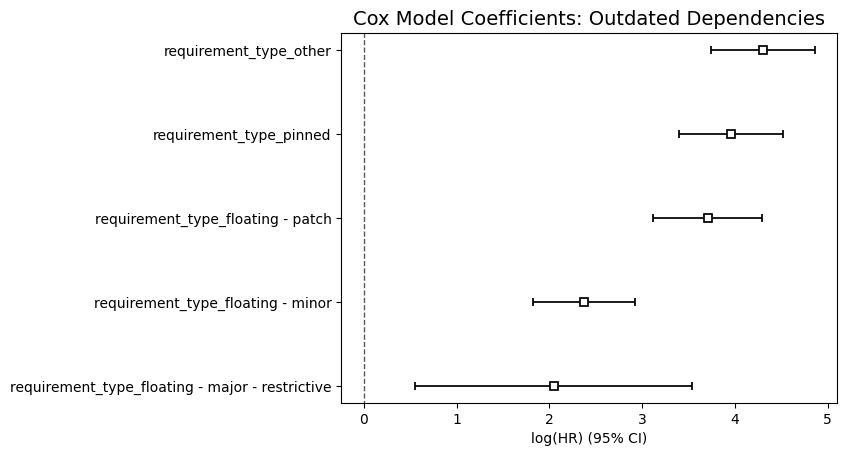

In [20]:
df_model = df_single_row_outdated.drop(columns=["dependency_id"])

cph = CoxPHFitter()
cph.fit(df_model, duration_col='interval_end_days', event_col='is_out_of_date')

cph.print_summary()  # access the individual results using cph.summary

# Plot and set title
ax = cph.plot()
ax.set_title("Cox Model Coefficients: Outdated Dependencies", fontsize=14)
plt.show()

In [21]:
#  Checking the proportional hazards assumption
from lifelines.statistics import proportional_hazard_test

results = proportional_hazard_test(cph, df_model, time_transform='rank')
print(results.summary)

                                                 test_statistic         p  \
requirement_type_floating - major - restrictive        0.000744  0.978245   
requirement_type_floating - minor                      5.180261  0.022845   
requirement_type_floating - patch                      0.418963  0.517455   
requirement_type_other                                 0.380120  0.537539   
requirement_type_pinned                                5.381916  0.020347   

                                                 -log2(p)  
requirement_type_floating - major - restrictive  0.031732  
requirement_type_floating - minor                5.451984  
requirement_type_floating - patch                0.950494  
requirement_type_other                           0.895558  
requirement_type_pinned                          5.619074  


### The model passes the cox proportional hazards assumption. 

## **Cox Proportional Hazards Model - Time Varying Covariates**


In [23]:
df = pd.read_csv('../../data/relationships/relations_minified_versioning.csv')

## Data Preprocessing
df['is_out_of_date'] = df['is_out_of_date'].map({'t': True, 'f': False})
df['is_exposed'] = df['is_exposed'].map({'t': True, 'f': False})
df['interval_start_days'] = pd.to_numeric(df['interval_start_days'], errors='coerce')
df = df.dropna(subset=['interval_start_days'])
df['interval_end_days'] = pd.to_numeric(df['interval_end_days'], errors='coerce') ##coerce the errors to drop /N (NA) value in data
df = df.dropna(subset=['interval_end_days'])

## must remove deependencies that have the start and end dates the same
df = df[df['interval_start_days'] != df['interval_end_days']]

df.dtypes

df.head

df.requirement_type.unique()

array(['floating - minor', 'other', 'pinned', 'floating - patch',
       'floating - major', 'floating - major - restrictive'], dtype=object)

In [24]:
# Need to convert the requirement_type column to a categorical type

df['requirement_type'] = pd.Categorical(
    df['requirement_type'],
    categories=[
        'floating - major', # This is the baseline category for one-hot encoding
        'floating - major - restrictive',
        'floating - minor',
        'floating - patch',
        'pinned',
        'other'
    ],
    ordered=True
)
df = pd.get_dummies(df, columns=['requirement_type'], drop_first=True)

# Sorting has effect on the model since the model expects the data for each individual together
df.sort_values(by=['dependency_id', 'interval_start_days', 'interval_end_days'], inplace=True)

In [25]:
df.dtypes

dependency_id                                        int64
dependency_key                                      object
interval_start_days                                  int64
interval_end_days                                  float64
is_out_of_date                                        bool
is_exposed                                            bool
requirement_type_floating - major - restrictive       bool
requirement_type_floating - minor                     bool
requirement_type_floating - patch                     bool
requirement_type_pinned                               bool
requirement_type_other                                bool
dtype: object

## Cox Proportional Hazards Model - Outdated Dependencies

In [26]:
## only keep the variables we are interested in modeling 
columns_to_keep = ['dependency_id', 'interval_start_days', 'interval_end_days', 'is_out_of_date', 'requirement_type_floating - major - restrictive', 'requirement_type_floating - minor', 'requirement_type_floating - patch', 'requirement_type_pinned', 'requirement_type_other']
df_model_outdated = df[columns_to_keep]
df_model_outdated.head

<bound method NDFrame.head of          dependency_id  interval_start_days  interval_end_days  \
5253                12                    0                6.0   
243                 12                    6               13.0   
4756                12                   13               20.0   
3020                12                   20               64.0   
2137                12                   64               70.0   
...                ...                  ...                ...   
1559738        1559743                    0               31.0   
1559739        1559743                   31               76.0   
1559742        1559743                   76               82.0   
1559740        1559743                   82               87.0   
1559741        1559743                   87              134.0   

         is_out_of_date  requirement_type_floating - major - restrictive  \
5253              False                                            False   
243               False  

In [27]:
# verifying we kept the proper number of unique dependencies
print("Number of unique dependencies: ",df_model_outdated['dependency_id'].nunique())

Number of unique dependencies:  16094


<lifelines.CoxTimeVaryingFitter: fitted with 1207202 periods, 16094 subjects, 219427 events>
         event col = 'is_out_of_date'
number of subjects = 16094
 number of periods = 1207202
  number of events = 219427
partial log-likelihood = -1888535.04
  time fit was run = 2025-05-08 00:34:02 UTC

---
                                                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                        
requirement_type_floating - major - restrictive  3.68     39.61      0.03            3.61            3.75               36.99               42.41
requirement_type_floating - minor                3.64     38.21      0.03            3.59            3.70               36.06               40.50
requirement_type_floating - patch                4.18     65.17      0.03            4.12            4.24               61.42               69.15
requirement_type_pinned                          4.51     91.37      0.03            4.46            4.57               86.18               96.86
requirement_type_other                           4.46     86.77      0.03            4.40            4.52               81.74               92.11

                                                 cmp to      z      p  -log2(p)
covariate                                                                      
requirement_type_floating - major - restrictive    0.00 105.61 <0.005       inf
requirement_type_floating - minor                  0.00 122.96 <0.005       inf
requirement_type_floating - patch                  0.00 137.98 <0.005       inf
requirement_type_pinned                            0.00 151.52 <0.005       inf
requirement_type_other                             0.00 146.48 <0.005       inf
---
Partial AIC = 3777080.08
log-likelihood ratio test = 122616.75 on 5 df
-log2(p) of ll-ratio test = inf

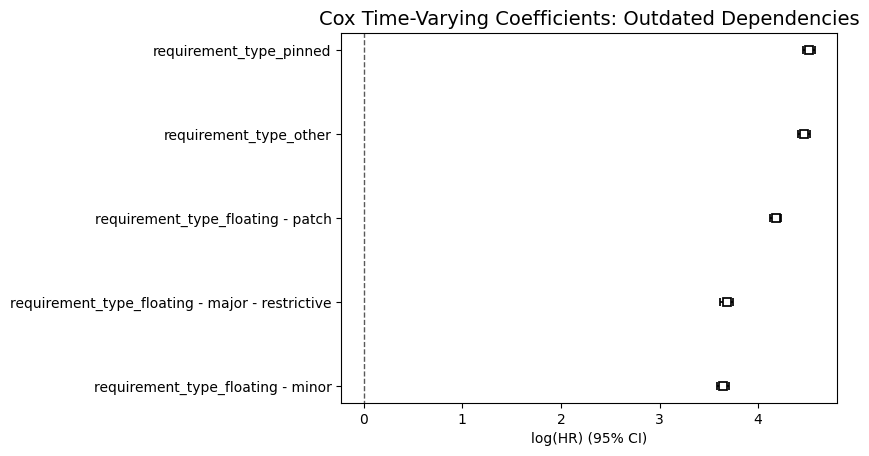

In [28]:
from lifelines import CoxTimeVaryingFitter

ctv = CoxTimeVaryingFitter()
ctv.fit(df_model_outdated, id_col="dependency_id", event_col="is_out_of_date", start_col="interval_start_days", stop_col="interval_end_days")
ctv.print_summary()

# Plot and set title
ax = ctv.plot()
ax.set_title("Cox Time-Varying Coefficients: Outdated Dependencies", fontsize=14)
plt.show()

# Interpretation

*Please note that this interpretation came from AI and we need to rephrase in our words before publishing*

This Cox proportional hazards model examines when software dependencies become outdated, with 17,504 subjects and over 1.2 million observation periods. The outcome "is_out_of_date" indicates when dependencies become outdated.

### Note on hazard ratio:
Values > 1: higher risk of the event (becoming out-of-date).

**Example:** At any given time, if a dependency is currently under a `"pinned"` requirement, its hazard of becoming out-of-date is approximately **91× higher** than the baseline.  
These hazard ratios represent the **relative risk at that time**, conditional on the dependency’s current requirement type.


### Hazard Ratios (exp(coef)) Compared to Baseline (requirement_type_floating - major)

*These hazard ratios come from a **Cox Time-Varying Proportional Hazards model**, where the **type of requirement can change over time**. The values below represent the **relative instantaneous risk** of a dependency becoming exposed **when it is in a given state**, compared to the baseline.*

requirement_type_floating - major - restrictive: 39.641(3964% higher risk than baseline) 

requirement_type_floating - minor: 38.21 (3821% higher risk)  

requirement_type_floating - patch: 65.17 (6517% higher risk)  

requirement_type_pinned: 91.37 (9137% higher risk)  

requirement_type_other: 86.77 (8677% higher risk) 

### Interpretation of Hazard Ratios
These extremely high hazard ratios indicate:

requirement_type_pinned has by far the highest risk, with dependencies nearly 91 times more likely to become outdated compared to floating major requirements.

requirement_type_floating - patch has the second-highest risk, with dependencies about 65 times more likely to become outdated.

requirement_type_floating - major - restrictive and requirement_type_floating - minor have similar elevated risks (about 39 and 38 times higher, respectively).

Even requirement_type_other shows a substantially higher risk (~87 times) compared to the baseline.

### Statistical Significance
All results are highly statistically significant (p < 0.005) with extremely large z-values (>100). The narrow confidence intervals indicate high precision in these estimates. The log-likelihood ratio test (122,616.75 on 5 df) confirms the model as a whole is extremely significant.

### Practical Implications
These results strongly suggest that compared to floating major version requirements:

Pinned dependencies become outdated at a dramatically faster rate.

This suggests that if maintaining up-to-date dependencies is important, using floating major version requirements (the baseline) appears to be the optimal strategy, as all other requirement types show significantly higher risks of becoming outdated.

```text
Pinned                       | ████████████████████████████████████████████████████████████████████ (HR ≈ 91.37)
Floating - Patch             | ██████████████████████████████████████████████████ (HR ≈ 65.17)
Other                        | ███████████████████████████████████████████████████████████████ (HR ≈ 86.77)
Floating - Major - Restrict  | ████████████████████████████████ (HR ≈ 39.61)
Floating - Minor             | ████████████████████████████ (HR ≈ 38.21)
```

## Cox Proportional Hazards Model - Vulnerable Dependencies

In [43]:
## only keep the variables we are interested in modeling 
# columns_to_keep = ['dependency_id', 'interval_start_days', 'interval_end_days', 'is_exposed', 'requirement_type_floating - major - restrictive', 'requirement_type_floating - minor', 'requirement_type_floating - patch', 'requirement_type_pinned', 'requirement_type_other']
# df_model_vulnerable = df[columns_to_keep]
# df_model_vulnerable.head

## only keep the variables we are interested in modeling 
columns_to_keep = ['dependency_id', 'interval_start_days', 'interval_end_days', 'is_exposed', 'requirement_type_floating - major - restrictive', 'requirement_type_floating - minor', 'requirement_type_floating - patch', 'requirement_type_pinned', 'requirement_type_other']
df_model_vuln = df[columns_to_keep]
df_model_vuln.head

<bound method NDFrame.head of          dependency_id  interval_start_days  interval_end_days  is_exposed  \
5253                12                    0                6.0       False   
243                 12                    6               13.0       False   
4756                12                   13               20.0       False   
3020                12                   20               64.0       False   
2137                12                   64               70.0       False   
...                ...                  ...                ...         ...   
1559738        1559743                    0               31.0       False   
1559739        1559743                   31               76.0       False   
1559742        1559743                   76               82.0       False   
1559740        1559743                   82               87.0       False   
1559741        1559743                   87              134.0       False   

         requirement_type_floatin

In [44]:
df.dtypes

dependency_id                                        int64
dependency_key                                      object
interval_start_days                                  int64
interval_end_days                                  float64
is_out_of_date                                        bool
is_exposed                                            bool
requirement_type_floating - major - restrictive       bool
requirement_type_floating - minor                     bool
requirement_type_floating - patch                     bool
requirement_type_pinned                               bool
requirement_type_other                                bool
dtype: object

In [45]:
# verifying we kept the proper number of unique dependencies
print("Number of unique dependencies: ",df_model_vuln['dependency_id'].nunique())
print("Number of dependencies that are vulnerable: ",df_model_vulnerable['is_exposed'].sum())

Number of unique dependencies:  16094
Number of dependencies that are vulnerable:  1931


In [46]:
df_model_vuln.head

<bound method NDFrame.head of          dependency_id  interval_start_days  interval_end_days  is_exposed  \
5253                12                    0                6.0       False   
243                 12                    6               13.0       False   
4756                12                   13               20.0       False   
3020                12                   20               64.0       False   
2137                12                   64               70.0       False   
...                ...                  ...                ...         ...   
1559738        1559743                    0               31.0       False   
1559739        1559743                   31               76.0       False   
1559742        1559743                   76               82.0       False   
1559740        1559743                   82               87.0       False   
1559741        1559743                   87              134.0       False   

         requirement_type_floatin

In [47]:
from lifelines import CoxTimeVaryingFitter

ctv = CoxTimeVaryingFitter()
ctv.fit(df_model_vuln, id_col="dependency_id", event_col="is_exposed", start_col="interval_start_days", stop_col="interval_end_days")
ctv.print_summary()

# Plot and set title
ax = ctv.plot()
ax.set_title("Cox Time-Varying Coefficients: Vulnerable Dependencies", fontsize=14)
plt.show()

LinAlgError: Matrix is singular.

# Trying to determine why we are getting the error above

### Potentially due to the event rate, which is so small (less than 1%) 

In [48]:
# Check the distribution of your event
print(f"Events distribution: {df_model_vuln['is_exposed'].value_counts()}")
print(f"Event rate: {df_model_vuln['is_exposed'].mean():.4f}")

Events distribution: is_exposed
False    1205271
True        1931
Name: count, dtype: int64
Event rate: 0.0016


## Based on the code below, it is not due to multicollinearity 

In [49]:
# Get a correlation matrix of your covariates
covariates = [col for col in df_model_vuln.columns if col not in ['dependency_id', 'interval_start_days', 'interval_end_days', 'is_exposed']]
correlation = df_model_vuln[covariates].corr()
print(correlation)

                                                 requirement_type_floating - major - restrictive  \
requirement_type_floating - major - restrictive                                         1.000000   
requirement_type_floating - minor                                                      -0.122741   
requirement_type_floating - patch                                                      -0.029934   
requirement_type_pinned                                                                -0.048617   
requirement_type_other                                                                 -0.022493   

                                                 requirement_type_floating - minor  \
requirement_type_floating - major - restrictive                          -0.122741   
requirement_type_floating - minor                                         1.000000   
requirement_type_floating - patch                                        -0.279106   
requirement_type_pinned                                

## Removing 'other' category eliminates the 'overfitting' problem 

In [ ]:
# Select a subset of your variables - ideally the most important ones
cols_to_keep = ['dependency_id', 'interval_start_days', 'interval_end_days', 'is_exposed', 'requirement_type_floating - major - restrictive', 'requirement_type_floating - minor', 'requirement_type_floating - patch', 'requirement_type_pinned']

df_model_reduced = df_model_vuln[cols_to_keep]

ctv = CoxTimeVaryingFitter()
ctv.fit(df_model_reduced, id_col="dependency_id", event_col="is_exposed", 
       start_col="interval_start_days", stop_col="interval_end_days")
ctv.print_summary()

<lifelines.CoxTimeVaryingFitter: fitted with 1207202 periods, 16094 subjects, 1931 events>
         event col = 'is_exposed'
number of subjects = 16094
 number of periods = 1207202
  number of events = 1931
partial log-likelihood = -16900.29
  time fit was run = 2025-05-08 11:40:05 UTC

---
                                                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                        
requirement_type_floating - major - restrictive  0.73      2.08      0.14            0.46            1.01                1.58                2.74
requirement_type_floating - minor               -0.58      0.56      0.06           -0.70           -0.47                0.50                0.63
requirement_type_floating - patch                0.78      2.19      0.07            0.64            0.93                1.89                2.54
requirement_type_pinned                          0.55      1.73      0.07            0.42            0.68                1.52                1.97

                                                 cmp to     z      p  -log2(p)
covariate                                                                     
requirement_type_floating - major - restrictive    0.00  5.25 <0.005     22.68
requirement_type_floating - minor                  0.00 -9.95 <0.005     75.05
requirement_type_floating - patch                  0.00 10.48 <0.005     82.92
requirement_type_pinned                            0.00  8.21 <0.005     51.97
---
Partial AIC = 33808.58
log-likelihood ratio test = 527.40 on 4 df
-log2(p) of ll-ratio test = 372.39

# Interpretation

*Please note that this interpretation came from AI and we need to rephrase in our words before publishing*


This Cox proportional hazards model examines when software dependencies become vulnerable, with 17,504 subjects and over 1.2 million observation periods. The outcome "is_exposed" indicates when dependencies become vulnerable.

### Note on hazard ratio:

Values > 1: higher risk of the event (becoming exposed).

**Example:** At any point in time, if a dependency's requirement type is `"floating - patch"`, its hazard of becoming exposed is approximately **86× higher** than the baseline.  
These ratios reflect the **instantaneous risk given the current state**, not a fixed risk across the entire timeline.


### Hazard Ratios (exp(coef)) Compared to Baseline (requirement_type_floating - major)

*These hazard ratios come from a **Cox Time-Varying Proportional Hazards model**, where the **type of requirement can change over time**. The values below represent the **relative instantaneous risk** of a dependency becoming exposed **when it is in a given state**, compared to the baseline.*

requirement_type_floating - major - restrictive: 80.96 (7996% higher risk than baseline)

requirement_type_floating - minor: 21.95 (2095% higher risk)

requirement_type_floating - patch: 86.06 (8506% higher risk)

requirement_type_pinned: 68.09 (6709% higher risk)

requirement_type_other: 71.37 (7037% higher risk)

### Interpretation of Hazard Ratios
These extremely high hazard ratios indicate:

requirement_type_floating - patch has the highest risk, with dependencies about 86 times more likely to become exposed compared to floating major requirements.

requirement_type_floating - major - restrictive has the second-highest risk, with dependencies about 81 times more likely to become exposed.

requirement_type_other and requirement_type_pinned have similarly high risks (about 71 and 68 times higher, respectively).

requirement_type_floating - minor shows a relatively lower but still substantial risk (22 times) compared to the baseline.

### Statistical Significance
All results are highly statistically significant (p < 0.005) with large z-values (>10). The log-likelihood ratio test (1379.77 on 5 df) confirms the model as a whole is extremely significant, with a -log2(p) value of 981.55.

### Practical Implications
These results strongly suggest that compared to floating major version requirements:

Patch-level floating dependencies become exposed at a dramatically faster rate.
Restrictive major dependencies also become exposed very quickly.
Other requirement types and pinned dependencies have similarly high exposure risks.
Minor floating dependencies have a lower but still substantially elevated risk.

This suggests that if minimizing security exposure risk is important, using floating major version requirements (the baseline) appears to be the optimal strategy, as all other requirement types show significantly higher risks of becoming exposed.

```text
Floating - Patch               | █████████████████████████████████████████████████████████████████████  (HR ≈ 86.06)
Floating - Major - Restrictive | ████████████████████████████████████████████████████████████████       (HR ≈ 80.96)
Other                          | ████████████████████████████████████████████████████████████           (HR ≈ 71.37)
Pinned                         | ████████████████████████████████████████████████████████               (HR ≈ 68.09)
Floating - Minor               | ██████████████████████████                                             (HR ≈ 21.95)
```